# Heart Failure Prediction

## Set up environment

In [1]:
#########################################################
#    Title: Heart Failure Prediction                    #
#   Author: Lauren McNamara                             #
#  Created: 4/24/2021                                   #                       
# Modified: 4/24/2021                                   #
#  Purpose: Quick reference for some ML and plotting    #
#           techniques                                  #
#########################################################


##############  Setup  ##############
# import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn import linear_model
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate

# set working directory
os.chdir("/Users/Lauren/Documents/Python/Practice")
# print(os.getcwd())
# print(os.listdir('.'))

# color palette
# source: https://learnui.design/tools/data-color-picker.html#palette
pdblue = '#003f5c'
plblue = '#444e86'
ppurple = '#955196'
ppink = '#dd5182'
porange = '#ff6e54'
pyellow = '#ffa600'
pgray = '#64666B'

## Get Data

In [2]:
hfdf = pd.read_csv('/Users/Lauren/Documents/Python/data/heart_failure_clinical_records_dataset.csv')
hfdf.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Data Analysis

In [3]:
# first look using pandas-profiling
profile = ProfileReport(hfdf, title="Pandas Profiling Report")
profile.to_widgets()

Generate report structure: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


Outcome of interest: DEATH_EVENT. 32% (n=96) of encounters had a death. Balancing the classes could be explored.

Continuous variables with a long tail:
<li>creatinine_phosphokinase
<li>platelets
<li>serum_creatinine
<li>serum sodium (left tail)

No missing data.

It is unclear what variable time represents. The description is "Follow-up period (days)". I think this is the length of time an individual was in the study before either a death occurred or the study ended. Individuals with a shorter time are probably more likely to be deceased, but I don't know that this would tell us anything for making future predictions. I'm going to drop the time variable from consideration.

In [4]:
# variable labels
varlabel = {'age':'Age'
        ,'anaemia':'Decrease of red blood cells or hemoglobin (boolean)'
        ,'creatinine_phosphokinase':'Level of the CPK enzyme in the blood (mcg/L)'
        ,'diabetes':'If the patient has diabetes (boolean)'
       ,'ejection_fraction':'Percentage of blood leaving the heart at each contraction (percentage)'
       ,'high_blood_pressure':'If the patient has hypertension (boolean)'
       ,'platelets':'Platelets in the blood (kiloplatelets/mL)'
       ,'serum_creatinine':'Level of serum creatinine in the blood (mg/dL)'
       ,'serum_sodium':'Level of serum sodium in the blood (mEq/L)'
       ,'sex':'Woman or man (binary)'
       ,'smoking':'If the patient smokes or not (boolean)'
       ,'time':'Follow-up period (days)'
       ,'DEATH_EVENT':'If the patient deceased during the follow-up period (boolean)'
        }

In [5]:
# identify boolean and continuous columns
cols_bool = ['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']
cols_cont = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']

# identify features and outcome
features = ['anaemia','diabetes','high_blood_pressure','sex','smoking','age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']
outcome = ['DEATH_EVENT']

hfdf2 = hfdf.loc[:, outcome+features]

In [6]:
hfdf2[cols_bool].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   anaemia              299 non-null    int64
 1   diabetes             299 non-null    int64
 2   high_blood_pressure  299 non-null    int64
 3   sex                  299 non-null    int64
 4   smoking              299 non-null    int64
 5   DEATH_EVENT          299 non-null    int64
dtypes: int64(6)
memory usage: 14.1 KB


In [7]:
hfdf2[cols_cont].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   creatinine_phosphokinase  299 non-null    int64  
 2   ejection_fraction         299 non-null    int64  
 3   platelets                 299 non-null    float64
 4   serum_creatinine          299 non-null    float64
 5   serum_sodium              299 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 14.1 KB


## Dataset Prep
Randomly sort dataset to prevent any data leakage/bias in CV based on ordering of data points. Split into X (features) and y (outcome), and reshape.

In [8]:
# randomly sort dataset to prevent any data leakage/bias in CV based on ordering of data points
hfdf2 = hfdf.sample(frac=1, random_state=424)

# split and reshape for model fitting
X = hfdf2[features]
y = hfdf2[outcome].values.ravel()

print('X shape', X.shape)
print('y shape',y.shape)

X shape (299, 11)
y shape (299,)


## Logistic Regression Pipeline
Build a pipeline to clean and standardize data.

Algorithms that are based on distances between the data points benefit from normalizing continuous features into the (0,1) range. If features have different scales, higher weight may be given to features with larger magnitudes. 

Tree-based algorithms that consider one variable at a time are not sensitive to differences in scales, but normalizing won't hurt.


(Source: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/#:~:text=Normalization%20is%20good%20to%20use,Nearest%20Neighbors%20and%20Neural%20Networks.)

In [9]:
# build a pipeline to normalize the continuous data and apply model
preprocessor = ColumnTransformer(
                    transformers=[
                            ('normalizer', preprocessing.MinMaxScaler(), cols_cont)
                    ]
                    ,remainder='passthrough'
    )
# access normalizer data: 
#   preprocessor.fit(hfdf2)
#   preprocessor.transformers_[0][1].data_range_

pipe = Pipeline(steps=[
                ('col_tx', preprocessor)
                ,('model', LogisticRegression())
])
# access pipeline data: 
#   pipe.fit(X, y)
#   pipe.score(X, y)                            -- mean accuracy
#   pipe[0].transformers_[0][1].data_range_     -- data ranges for normalization


In [10]:
# cross validation
scoring=['accuracy','roc_auc','f1','precision','recall','balanced_accuracy']
nfold = 5

scores = cross_validate(pipe, X, y, cv=nfold, scoring=scoring
                            ,return_train_score=True, return_estimator=True)

In [11]:
for s in scoring:
    cv_test_detail = {}
    cv_train_detail = {}
    cv_test_mean = {}
    cv_train_mean = {}    
    
    cv_test_detail[s] = scores['test_'+s]
    cv_test_mean[s] = scores['test_'+s].mean()
    cv_train_detail[s] = scores['train_'+s]
    cv_train_mean[s] = scores['train_'+s].mean()

    print('score:',s)
    print('test:', cv_test_detail[s], 'mean', cv_test_mean[s])
    print('train:', cv_train_detail[s], 'mean', cv_train_mean[s])

    print('--------')
    print('')

score: accuracy
test: [0.71666667 0.78333333 0.78333333 0.7        0.6440678 ] mean 0.7254802259887005
train: [0.74058577 0.71966527 0.74476987 0.75732218 0.75833333] mean 0.7441352859135286
--------

score: roc_auc
test: [0.76636714 0.84595635 0.85109114 0.7575     0.63421053] mean 0.7710250320924261
train: [0.79886163 0.78354978 0.78483245 0.80424604 0.82344036] mean 0.7989860550241564
--------

score: f1
test: [0.37037037 0.48       0.48       0.30769231 0.27586207] mean 0.382784949405639
train: [0.42592593 0.33663366 0.44036697 0.43137255 0.45283019] mean 0.417425859893636
--------

score: precision
test: [0.625      1.         1.         0.66666667 0.4       ] mean 0.7383333333333333
train: [0.74193548 0.70833333 0.75       0.84615385 0.82758621] mean 0.7748017740509398
--------

score: recall
test: [0.26315789 0.31578947 0.31578947 0.2        0.21052632] mean 0.26105263157894737
train: [0.2987013  0.22077922 0.31168831 0.28947368 0.31168831] mean 0.28646616541353387
--------

sco

## Generic modeling pipeline
Build a generic pipeline that can fit different types of models.

In [12]:
def make_pipes(model_obj):
    """build a pipeline to normalize the continuous data and apply model"""
    preprocessor = ColumnTransformer(
                        transformers=[
                                ('normalizer', preprocessing.MinMaxScaler(), cols_cont)
                        ]
                        ,remainder='passthrough'
        )
    # access normalizer data: 
    #   preprocessor.fit(hfdf2)
    #   preprocessor.transformers_[0][1].data_range_

    pipe = Pipeline(steps=[
                    ('col_tx', preprocessor)
                    ,('model', model_obj)
    ])
    # access pipeline data: 
    #   pipe.fit(X, y)
    #   pipe.score(X, y)                            -- mean accuracy
    #   pipe[0].transformers_[0][1].data_range_     -- data ranges for normalization

    return pipe

In [13]:
# set up modeling
scoring=['accuracy','roc_auc','f1','precision','recall','balanced_accuracy']
nfold = 10

modmeth = {
    'logistic regression, no penalty': LogisticRegression(penalty='none')
    ,'logistic regression, l2 penalty': LogisticRegression(penalty='l2')
    ,'random forest, all predictors': RandomForestClassifier(n_estimators = 11)
    ,'random forest, 5 predictors': RandomForestClassifier(n_estimators = 5)
    ,'xgboost': GradientBoostingClassifier()
}

# dictionaries to store score results
# will be nested as metric -- method -- test/train result      
cv_test_detail = {}
cv_train_detail = {}
cv_test_mean = {}
cv_train_mean = {}   

# nested dictionary stores results
for s in scoring:
    cv_test_detail[s] = {}
    cv_train_detail[s] = {}
    cv_test_mean[s] = {}
    cv_train_mean[s] = {}

In [14]:
# fit different models
for m in modmeth: 
    pipe = make_pipes(modmeth[m])
    scores = cross_validate(pipe, X, y, cv=nfold, scoring=scoring
                                ,return_train_score=True, return_estimator=True)
    
    for s in scoring:
        cv_test_detail[s][m] = scores['test_'+s]
        cv_test_mean[s][m] = scores['test_'+s].mean()
        cv_train_detail[s][m] = scores['train_'+s]
        cv_train_mean[s][m] = scores['train_'+s].mean()

In [30]:
# make dfs with model results
cv_test_mean_df = {}
for s in scoring:
    cv_test_mean_df[s] = pd.DataFrame.from_dict(cv_test_mean[s]
                                ,orient='index'
                                ,columns=['value']) \
                                .reset_index(drop=False)    \
                                .rename(columns={'index':'modmeth'})
    cv_test_mean_df[s]['max'] = 0
    cv_test_mean_df[s].loc[cv_test_mean_df[s].value == cv_test_mean_df[s].value.max(),'max'] = 1

In [15]:
# create dictionary of train/test results with levels: 
# metric -- method -- mean test/mean train
for s in scoring:
    print('score:',s)
    for m in modmeth.keys():
        print('model method:',m)
        print('test mean:', round(cv_test_mean[s][m],3))
        print('train mean:', round(cv_train_mean[s][m],3))

    print('test best:', max(cv_test_mean[s], key=cv_test_mean[s].get))
    print('train best:', max(cv_test_mean[s], key=cv_test_mean[s].get))

    print('--------')
    print('')

score: accuracy
model method: logistic regression, no penalty
test mean: 0.752
train mean: 0.763
model method: logistic regression, l2 penalty
test mean: 0.725
train mean: 0.748
model method: random forest, all predictors
test mean: 0.745
train mean: 0.99
model method: random forest, 5 predictors
test mean: 0.678
train mean: 0.968
model method: xgboost
test mean: 0.712
train mean: 0.964
test best: logistic regression, no penalty
train best: logistic regression, no penalty
--------

score: roc_auc
model method: logistic regression, no penalty
test mean: 0.785
train mean: 0.809
model method: logistic regression, l2 penalty
test mean: 0.775
train mean: 0.798
model method: random forest, all predictors
test mean: 0.753
train mean: 0.999
model method: random forest, 5 predictors
test mean: 0.726
train mean: 0.991
model method: xgboost
test mean: 0.751
train mean: 0.996
test best: logistic regression, no penalty
train best: logistic regression, no penalty
--------

score: f1
model method: lo

### Plot results

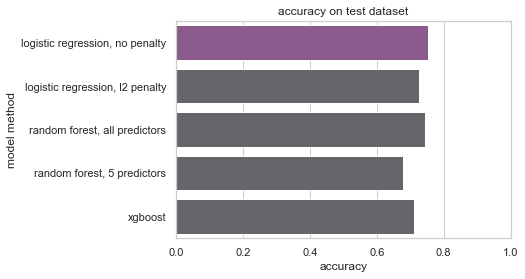

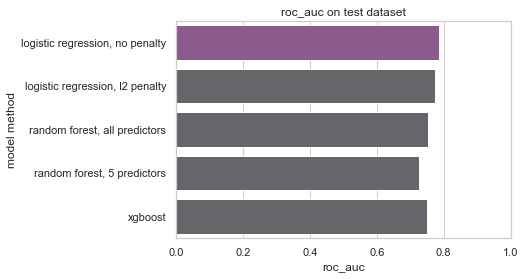

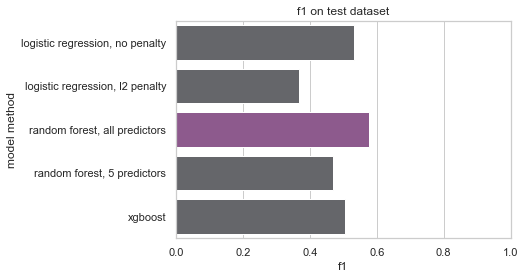

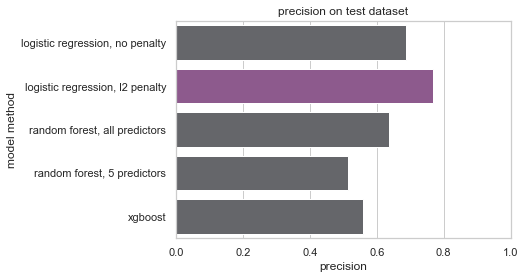

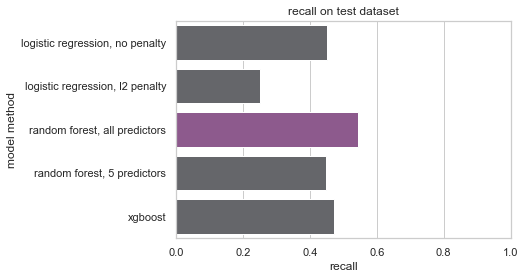

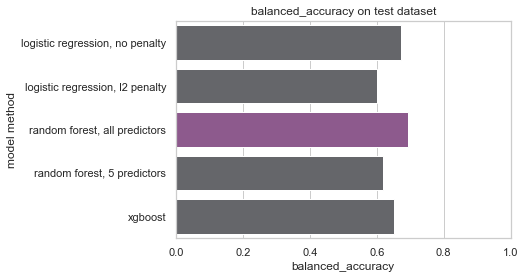

In [57]:
sns.set(style="whitegrid")

for s in scoring:
    color = [ppurple if x == 1 else pgray for x in cv_test_mean_df[s]['max']]
    ax = sns.barplot(x='value',y='modmeth',data=cv_test_mean_df[s], palette=color)
    ax.set(xlabel=s, ylabel='model method', xlim=(0,1))
    plt.title(s+' on test dataset')
    plt.show()

### Tally votes for each model
Tally the number of times each model method optimized a scoring metric.

In [52]:
allrslt = pd.DataFrame()
for s in scoring:
    df = cv_test_mean_df[s]
    df['metric'] = s
    allrslt = allrslt.append(df)


In [53]:
votes = allrslt.groupby('modmeth').agg({'max':sum}) \
        .reset_index(drop=False)    \
        .rename(columns={'max':'nvotes'})
votes

,modmeth,nvotes
0,"logistic regression, l2 penalty",1
1,"logistic regression, no penalty",2
2,"random forest, 5 predictors",0
3,"random forest, all predictors",3
4,xgboost,0


In [54]:
winner = votes.loc[votes.nvotes == votes.nvotes.max()]
winner

,modmeth,nvotes
3,"random forest, all predictors",3


In [55]:
winmeth = winner.iloc[0,0]
allrslt.loc[allrslt.modmeth == winmeth]

,modmeth,value,max,metric
2,"random forest, all predictors",0.745172,0,accuracy
2,"random forest, all predictors",0.752790,0,roc_auc
2,"random forest, all predictors",0.578104,1,f1
2,"random forest, all predictors",0.635458,0,precision
2,"random forest, all predictors",0.544444,1,recall
2,"random forest, all predictors",0.693294,1,balanced_accuracy


## Summary and Discussion

The method that maximized the most metrics was 'random forest, all predictors' which maximized f1, recall, and balanced accuracy.

These results should be reviewed with stakeholders to understand which metrics are best to optimize for the business problem at hand. 

Precision is the positive predictive value, or number of true positives divided by the number of predictied positives. Recall is the true positive rate, sensitivity, or number of true positive predictions divided by the number of actual positives in the data.

If we want to minimize false positives, or the number of people told they are at risk of dying of heart failure that won't, we want to maximize precision.

If we want to minimize false negatives, or the number of people told they are not at risk of dying of heart failure, but will die of heart failure, we want to maximize recall. 

If we want to maximize both precision and recall, we would pay most attention to F1 score, the harmonic mean of precision and recall.

In this scenario, it is likely worse to predict a false death than a false survival - individuals predicted to die would receive more attention and health intervention than those predicted to survive. Thus we may prefer to maximize precision, and the logistic regression with l2 penalty model. 

It is also noteworthy that testing indicated the best method varied with choice of the number of folds for cross-validation. This should be explored further. The data is imbalanced with 1/3 having the death outcome; techniques to balance the data (such as upsampling, downsampling, or SMOTE) should be explored as well to see if this increases our prediction metrics.

Variable importance plots should also be analyzed to determine what the prediction is being based on. 